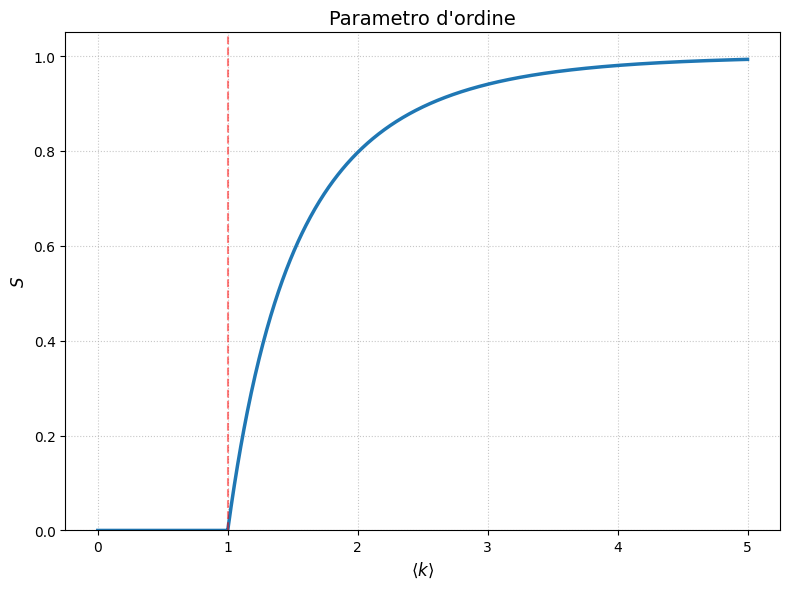

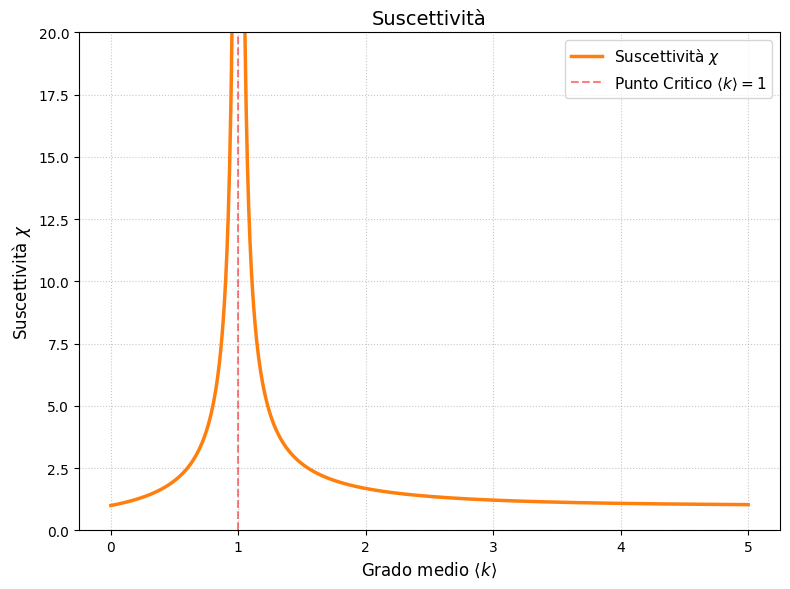

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

def theoretical_S_chi(k_mean):
    """
    Calcola S (dimensione del cluster gigante) e chi (suscettività)
    in funzione del grado medio k_mean.
    """
    # Gestione esplicita della divergenza al punto critico
    if np.isclose(k_mean, 1.0):
        return 0.0, np.inf

    if k_mean < 1.0:
        # Regime subcritico
        S = 0.0
        chi = 1.0 / (1.0 - k_mean)
    else:
        # Regime supercritico
        func = lambda x: x - 1 + np.exp(-k_mean * x)
        S = fsolve(func, x0=0.5)[0]
        chi = 1.0 / (1.0 - k_mean + k_mean * S)

    return S, chi

# 1. Array dei gradi medi
k_theory = np.linspace(0, 5, 1000)

# 2. Calcolo dei valori
S_theory = []
chi_theory = []

for k in k_theory:
    S, chi = theoretical_S_chi(k)
    S_theory.append(S)
    chi_theory.append(chi)

# --- PRIMO GRAFICO: Parametro d'ordine S ---
fig1, ax1 = plt.subplots(figsize=(8, 6)) # Creiamo una figura separata per S
ax1.plot(k_theory, S_theory, color='tab:blue', linewidth=2.5)
ax1.axvline(x=1.0, color='red', linestyle='--', alpha=0.5)
ax1.set_xlabel(r"$\langle k \rangle$", fontsize=12) # Aggiungi etichetta x per il primo grafico
ax1.set_ylabel(r'$S$', fontsize=12)
ax1.set_title("Parametro d'ordine", fontsize=14)
ax1.set_ylim(0, 1.05)
ax1.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

# --- SECONDO GRAFICO: Suscettività chi ---
fig2, ax2 = plt.subplots(figsize=(8, 6)) # Creiamo una figura separata per chi
ax2.plot(k_theory, chi_theory, color='tab:orange', linewidth=2.5, label=r"Suscettività $\chi$")
ax2.axvline(x=1.0, color='red', linestyle='--', alpha=0.5, label=r"Punto Critico $\langle k \rangle = 1$")
ax2.set_xlabel(r"Grado medio $\langle k \rangle$", fontsize=12)
ax2.set_ylabel(r"Suscettività $\chi$", fontsize=12)
ax2.set_title('Suscettività', fontsize=14)
ax2.set_ylim(0, 20)
ax2.grid(True, linestyle=':', alpha=0.7)
ax2.legend(loc='upper right', fontsize=11)
plt.tight_layout()
plt.show()

In [10]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, curve_fit
import time
from joblib import Parallel, delayed

# --- 2. LA FUNZIONE "WORKER" PER LA PARALLELIZZAZIONE ---
def simulate_single_graph(N, p):
    """
    Questa funzione viene eseguita in parallelo da core diversi.
    Crea UN grafo, calcola S e chi, e li restituisce.
    """
    G = nx.fast_gnp_random_graph(N, p)
    comp_sizes = [len(c) for c in nx.connected_components(G)]
    comp_sizes.sort(reverse=True)
    
    if len(comp_sizes) == 0:
        return 0.0, 0.0
        
    S_val = comp_sizes[0] / N
    
    finite_clusters = comp_sizes[1:]
    if len(finite_clusters) > 0:
        sum_sq = sum(s**2 for s in finite_clusters)
        sum_lin = sum(finite_clusters)
        chi_val = sum_sq / sum_lin
    else:
        chi_val = 0.0
        
    return S_val, chi_val


# --- 3. SIMULAZIONE NUMERICA PARALLELIZZATA ---
N = 100000 
M = 10     

k_sim = np.concatenate([
    np.linspace(0.1, 0.95, 15),
    np.linspace(0.96, 1.04, 15),
    np.linspace(1.05, 1.35, 15),
    np.linspace(1.4, 2.0, 10),
    np.linspace(2.1, 5.0, 10)
])
k_sim.sort()

S_mean, S_err = [], []
chi_mean, chi_err = [], []

print(f"Avvio simulazione PARALLELA per {len(k_sim)} punti (N={N}, M={M})...")
print("I tuoi processori stanno lavorando a pieno regime. Attendi...")
start_time = time.time()

for k in k_sim:
    p = k / (N - 1)
    
    # QUI AVVIENE LA MAGIA: Lanciamo M simulazioni in parallelo su tutti i core (n_jobs=-1)
    # joblib restituisce una lista di tuple [(S1, chi1), (S2, chi2), ..., (SM, chiM)]
    risultati = Parallel(n_jobs=-1)(
        delayed(simulate_single_graph)(N, p) for _ in range(M)
    )
    
    # Separiamo i risultati di S e chi per fare le medie
    S_ensemble = [res[0] for res in risultati]
    chi_ensemble = [res[1] for res in risultati]
            
    # Calcolo media e SEM
    S_mean.append(np.mean(S_ensemble))
    S_err.append(np.std(S_ensemble, ddof=1) / np.sqrt(M))
    
    chi_mean.append(np.mean(chi_ensemble))
    chi_err.append(np.std(chi_ensemble, ddof=1) / np.sqrt(M))

k_sim = np.array(k_sim)
S_mean, S_err = np.array(S_mean), np.array(S_err)
chi_mean, chi_err = np.array(chi_mean), np.array(chi_err)

tempo_totale = time.time() - start_time
print(f"Simulazione completata in {tempo_totale:.2f} secondi!")

Avvio simulazione PARALLELA per 65 punti (N=100000, M=10)...
I tuoi processori stanno lavorando a pieno regime. Attendi...
Simulazione completata in 282.16 secondi!


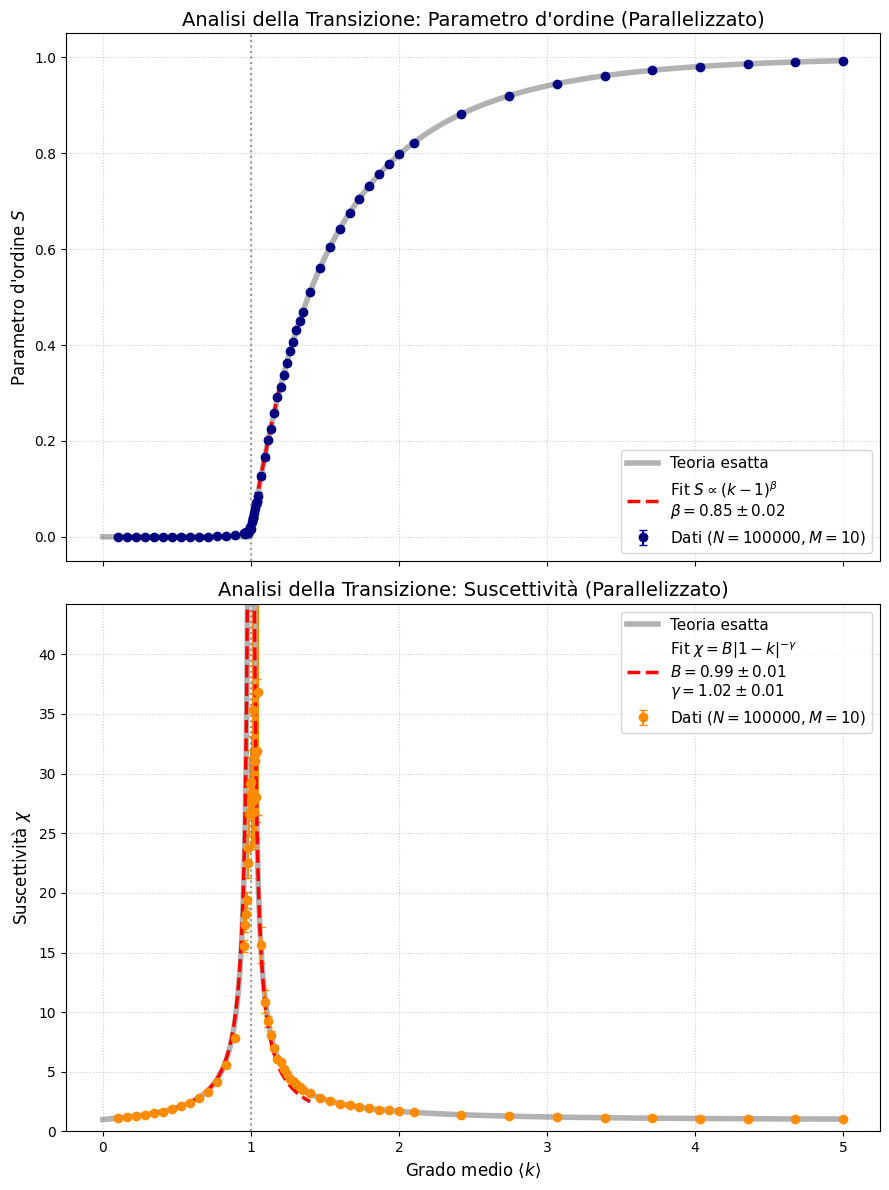

In [14]:
# --- 4. ANALISI QUANTITATIVA E GRAFICI ---
def fit_S(k, A, beta): return A * (k - 1.0)**beta
def fit_chi_symmetric(k, B, gamma): return B * np.abs(1.0 - k)**(-gamma)

mask_S = (k_sim > 1.00) & (k_sim < 1.2)
popt_S, pcov_S = curve_fit(fit_S, k_sim[mask_S], S_mean[mask_S], 
                           sigma=S_err[mask_S], absolute_sigma=True, p0=[2.0, 1.0])
err_fit_S = np.sqrt(np.diag(pcov_S))

mask_chi_globale = ((k_sim > 0.5) & (k_sim < 0.95)) | ((k_sim > 1.05) & (k_sim < 1.35))
popt_chi, pcov_chi = curve_fit(fit_chi_symmetric, k_sim[mask_chi_globale], chi_mean[mask_chi_globale], 
                               sigma=chi_err[mask_chi_globale], absolute_sigma=True, p0=[1.0, 1.0])
err_fit_chi = np.sqrt(np.diag(pcov_chi))

# Grafici
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 12), sharex=True)

# S vs k
ax1.plot(k_theory, S_theory, 'k-', alpha=0.3, lw=4, label='Teoria esatta')
ax1.errorbar(k_sim, S_mean, yerr=S_err, fmt='o', c='navy', markersize=6, 
             capsize=3, label=f'Dati ($N={N}, M={M}$)')

k_fit_plot_S = np.linspace(1.01, 1.2, 100)
ax1.plot(k_fit_plot_S, fit_S(k_fit_plot_S, *popt_S), 'r--', lw=2.5, 
         label=f'Fit $S \\propto (k-1)^{{\\beta}}$\n$\\beta = {popt_S[1]:.2f} \\pm {err_fit_S[1]:.2f}$')

ax1.axvline(x=1.0, color='gray', linestyle=':', alpha=0.8)
ax1.set_ylabel("Parametro d'ordine $S$", fontsize=12)
ax1.set_title("Analisi della Transizione: Parametro d'ordine (Parallelizzato)", fontsize=14)
ax1.set_ylim(-0.05, 1.05)
ax1.grid(True, linestyle=':', alpha=0.6)
ax1.legend(fontsize=11)

# chi vs k
ax2.plot(k_theory, chi_theory, 'k-', alpha=0.3, lw=4, label='Teoria esatta')
ax2.errorbar(k_sim, chi_mean, yerr=chi_err, fmt='o', c='darkorange', markersize=6, 
             capsize=3, label=f'Dati ($N={N}, M={M}$)')

k_fit_plot_sub = np.linspace(0.1, 0.98, 100)
k_fit_plot_sup = np.linspace(1.02, 1.4, 100)

ax2.plot(k_fit_plot_sub, fit_chi_symmetric(k_fit_plot_sub, *popt_chi), 
         'r--', lw=2.5, label=f'Fit $\\chi = B|1-k|^{{-\\gamma}}$\n$B = {popt_chi[0]:.2f} \\pm {err_fit_chi[0]:.2f}$\n$\\gamma = {popt_chi[1]:.2f} \\pm {err_fit_chi[1]:.2f}$')
ax2.plot(k_fit_plot_sup, fit_chi_symmetric(k_fit_plot_sup, *popt_chi), 'r--', lw=2.5)

ax2.axvline(x=1.0, color='gray', linestyle=':', alpha=0.8)
ax2.set_xlabel("Grado medio $\\langle k \\rangle$", fontsize=12)
ax2.set_ylabel("Suscettività $\\chi$", fontsize=12)
ax2.set_title("Analisi della Transizione: Suscettività (Parallelizzato)", fontsize=14)
ax2.set_ylim(0, max(chi_mean)*1.2)
ax2.grid(True, linestyle=':', alpha=0.6)
ax2.legend(fontsize=11)

plt.tight_layout()
plt.show()